# Effect of input on estimated model

# Experiment 4

- How do the estimation results change for different inputs?
- Try a sinusoid and multisine


In [1]:
import sysid_pem as sid
import numpy as np
import scipy as sp
import control as ct
import matplotlib.pyplot as plt

In [18]:
F0 = np.real(np.convolve([1, -0.2+0.8j],np.convolve([1, -0.2-0.8j],np.convolve([1, -0.6+0.7j],[1, -0.6-0.7j]))))
B0 = np.real(np.convolve([1, -0.7+0.2j],[1, -0.7-0.2j]))
C0 = np.real(np.convolve([1, 0.1+0.9j],[1, 0.1-0.9j]))
D0 = np.real(np.convolve([1, -0.5+0.75j],[1, -0.5-0.75j]))
 
sigma_v = 0.1
N = 1000 
Ts = 0.01
t = np.linspace(0,10-Ts,N)

G0 = ct.tf(B0,F0,Ts)
H0 = ct.tf(C0,D0,Ts)
print('Data Generating System:')
print('Plant:', G0)
print('Noise:', H0)

f0 = 2
f1 = 10
f2 = 20
f3 = 40
#u = np.random.randn(N)
u = np.sin(2*np.pi*f0*t) + np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t) + np.sin(2*np.pi*f3*t)
tt,y_noise_free = ct.forced_response(G0,U=u)

Data Generating System:
Plant: 
            z^2 - 1.4 z + 0.53
------------------------------------------
z^4 - 1.6 z^3 + 2.01 z^2 - 1.156 z + 0.578

dt = 0.01

Noise: 
z^2 + 0.2 z + 0.82
------------------
 z^2 - z + 0.8125

dt = 0.01



Iteration: 0
Estimated plant transfer function: 
        1.007 z^4 - 1.385 z^3 + 0.5119 z^2
--------------------------------------------------
z^6 - 1.59 z^5 + 2.019 z^4 - 1.16 z^3 + 0.5977 z^2

dt = 0.01

Iteration: 1
Estimated plant transfer function: 
        0.9901 z^4 - 1.418 z^3 + 0.5595 z^2
----------------------------------------------------
z^6 - 1.632 z^5 + 2.034 z^4 - 1.183 z^3 + 0.5755 z^2

dt = 0.01

Iteration: 2
Estimated plant transfer function: 
       0.9774 z^4 - 1.401 z^3 + 0.5449 z^2
--------------------------------------------------
z^6 - 1.614 z^5 + 2.01 z^4 - 1.16 z^3 + 0.5631 z^2

dt = 0.01



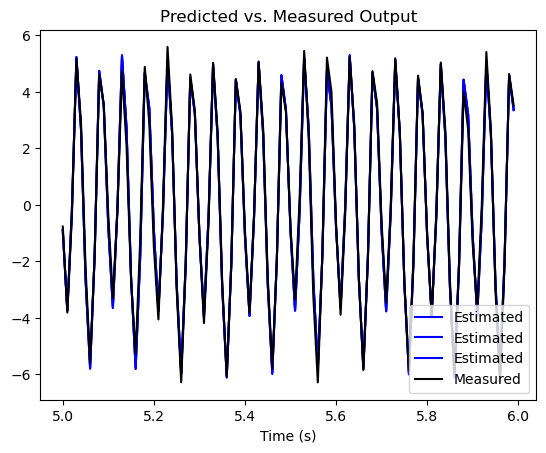

In [19]:
nf = 4
nb = 3
nc = 0
nd = 0
na = nf
nk = 2
n_arx = [na, nb, nk]
n_oe = [nb, nc, nd, nf, nk]




figl,ax = plt.subplots(1)
num_iter = 3
V_opt_oe = np.empty(num_iter)
G_est = np.empty(num_iter,dtype=object)
for ii in range(num_iter):
    print('Iteration:',ii)

    e = np.random.randn(N)    
    tt,v = ct.forced_response(H0,U=e)
    y = y_noise_free + sigma_v*v
   
    theta_arx = sid.V_arx_lin_reg(n_arx,y,u)
    theta_oe = np.concatenate((theta_arx[n_arx[0]:n_arx[0]+n_arx[1]],theta_arx[0:n_arx[0]]))  
    optimization_results_oe = sp.optimize.least_squares(sid.V_box_jenkins, theta_oe, jac=sid.jac_V_bj, args=(n_oe,y,u))

    V_opt_oe[ii] = np.sum(optimization_results_oe.fun**2)
    G_est[ii], H_est = sid.theta_2_tf_box_jenkins(optimization_results_oe.x,n_oe,Ts)
    #G_est[ii],H_est = sid.theta_2_tf_arx(theta_arx,n_arx,Ts)
    print('Estimated plant transfer function:', G_est[ii])
    y_hat = sid.y_hat_box_jenkins(optimization_results_oe.x,n_oe,y,u)
    ax.plot(t[500:600],y_hat[500:600],'b',label='Estimated')

ax.plot(t[500:600],y[500:600],'k',label='Measured')
ax.set_title('Predicted vs. Measured Output')
ax.set_xlabel('Time (s)')
ax.legend()


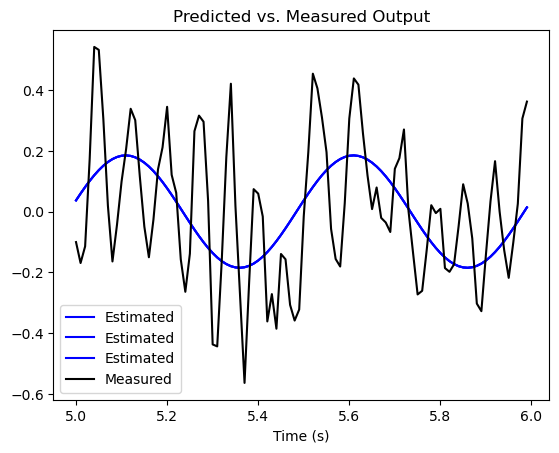

In [4]:
fig,ax = plt.subplots(1)
for ii in range(num_iter):
    y_hat = sid.y_hat_box_jenkins(theta_oe,n_oe,y,u)
    ax.plot(t[500:600],y_hat[500:600],'b',label='Estimated')
ax.plot(t[500:600],y[500:600],'k',label='Measured')
ax.set_title('Predicted vs. Measured Output')
ax.set_xlabel('Time (s)')
ax.legend()

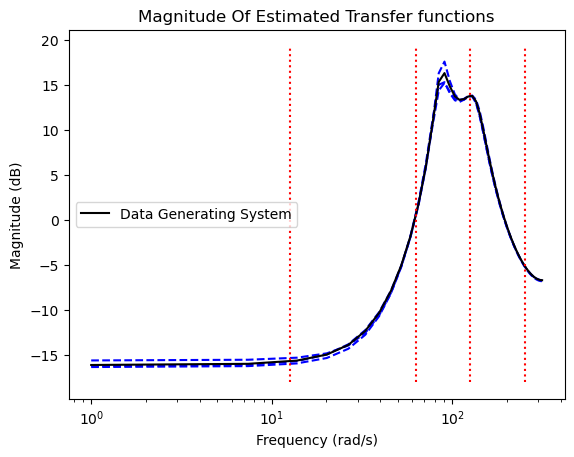

In [21]:

fig,ax = plt.subplots(1)
omega0 = np.linspace(1,100*np.pi)
for ii in range(num_iter):
    mag,phase,omega = ct.bode_plot(G_est[ii],omega=omega0,plot=False)
    ax.semilogx(omega,20*np.log10(mag),'b--',label='_Estimated')
mag,phase,omega = ct.bode_plot(G0,omega=omega0,plot=False)
ax.semilogx(omega,20*np.log10(mag),'k',label='Data Generating System')
ylim = ax.get_ylim()
ax.plot([2*np.pi*f0, 2*np.pi*f0],ylim,'r:',label='_f0')
ax.plot([2*np.pi*f1, 2*np.pi*f1],ylim,'r:',label='_f0')
ax.plot([2*np.pi*f2, 2*np.pi*f2],ylim,'r:',label='_f0')
ax.plot([2*np.pi*f3, 2*np.pi*f3],ylim,'r:',label='_f0')
ax.set_title('Magnitude Of Estimated Transfer functions')
ax.set_ylabel('Magnitude (dB)')
ax.set_xlabel('Frequency (rad/s)')
ax.legend()

# Frequency Domain point of view

Suppose that we have excited the system with two different frequencies. We can then construct a Frequency Response Function that has two points. 

Suppose that we wish to estimate a transfer function that has the same FRF as the estimated FRF. 